# 멋진 단어사전 만들기

평가문항	상세기준
> 1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?	코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?  
> 2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?	SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.  
> 3. SentencePiece의 성능을 다각도로 비교분석하였는가?	SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.  

## 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


## Step 1. SentencePiece 설치하기
SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

- google/sentencepiece  

위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다.

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.
```
$ pip install sentencepiece
```

## Step 2. SentencePiece 모델 학습
앞서 배운 tokenize() 함수를 기억하나요? 다시 한번 상기시켜드릴게요!

In [2]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

위와 같이 tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것입니다.

그럼 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.

In [ ]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 korean_spm.model 파일과 korean_spm.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

어떻습니까? SentencePiece의 토크나이징 실력이 괜찮은 것 같습니다.

## Step 3. Tokenizer 함수 작성
우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.
> 1.매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.  
> 2.생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.  
> 3.리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?  

In [ ]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기
네이버 영화리뷰 감정 분석 태스크가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.  

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요. (여러분들은 fasttext(https://wikidocs.net/22883)로 사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는 형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다. 기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)  

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [ ]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [6]:
# 데이터를 읽어오기
train_data = pd.read_table('~/aiffel/workspace/GD_NLP/D-1/ratings_train.txt')
test_data = pd.read_table('~/aiffel/workspace/GD_NLP/D-1/ratings_test.txt')

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train_data.head()

train 데이터 사이즈: 150000
test 데이터 사이즈: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
# 중복 및 결측치 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train 데이터 사이즈: 146182
test 데이터 사이즈: 49157


In [8]:
# 훈련 데이터와 시험 데이터 합치기
data = list(train_data['document']) + list(test_data['document'])

print("Data Size:", len(data))

print("Example:")
for sen in data[0:100][::20]: print(">>", sen)

Data Size: 195339
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


### 데이터 정제하기

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/tmp/ipykernel_37/4031225536.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


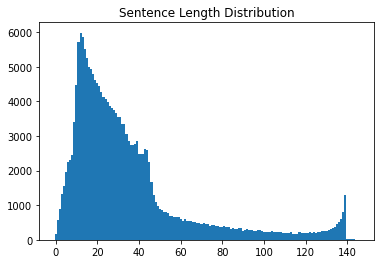

In [9]:
# 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이분포를 막대그래프로 표현해주는 소스
min_len = 999
max_len = 0
sum_len = 0

for sen in data: 
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [10]:
# 길이 체크 함수로 문장 길이 확인하기
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

# 훈련 데이터 길이가 1인 문장 확인해보기            
check_sentence_with_length(data, 1)
print("-------------------------------------")
# 훈련 데이터 길이가 146인 문장 확인해보기            
check_sentence_with_length(data, 146)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡
-------------------------------------
"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


In [11]:
# 길이 별로 확인이 필요해보이는 문장 확인하기
for idx, _sum in enumerate(sentence_length):
    # 문장 내 단어의 개수가 5000을 초과하는 인덱스를 추출
    if _sum > 5000:
        print("Outlier Index:", idx+1)

Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17


In [12]:
check_sentence_with_length(data, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


/tmp/ipykernel_37/614249671.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


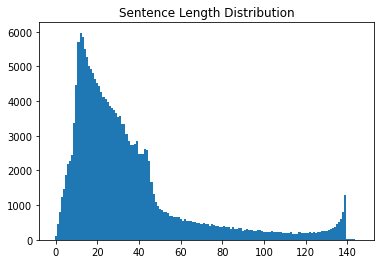

In [13]:
# 데이터에서 중복 제거하기
min_len= 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(data))  # set를 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

/tmp/ipykernel_37/533010103.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


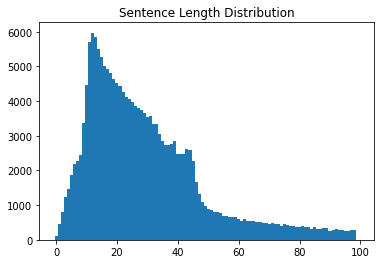

In [14]:
# 문장의 길이를 기준으로 데이터 필터링 수행
max_len = 100
min_len = 1

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려보자 
# 아래 나온 그래프는 최종 데이터 분포
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### SentencePiece 모델 학습

In [15]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# 디폴트 --model_type = 'unigram'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

# --model_type = 'bpe'
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=naver_review_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l naver_review_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_review_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_review_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab

-rw-r--r-- 1 root root 370628 Nov  7 06:34 naver_review_spm_bpe.model
-rw-r--r-- 1 root root 115824 Nov  7 06:34 naver_review_spm_bpe.vocab
-rw-r--r-- 1 root root 375092 Nov  7 06:34 naver_review_spm.model
-rw-r--r-- 1 root root 144518 Nov  7 06:34 naver_review_spm.vocab


#### Unigram

In [16]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_uni = spm.SentencePieceProcessor() 
s_uni.Load('naver_review_spm.model') # unigram 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[1510, 10, 425, 15, 1345, 10, 137, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


#### BPE

In [17]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_bpe = spm.SentencePieceProcessor() 
s_bpe.Load('naver_review_spm_bpe.model') # bpe 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[5065, 913, 6551, 6283, 1472, 6279, 6385, 6273, 6271]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### 학습된 모델로 sp_tokenize() 메소드 구현하기
Unigram

In [18]:
def sp_tokenize_uni(s_uni, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))

    with open("./naver_review_spm.vocab", 'r') as f: # unigram 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인해
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, my_corpus)
print(tensor_uni)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  563 3385   14 1389
  2226    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1584 2280  253  589

In [20]:
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, data)
print(tensor_uni.shape)

(195339, 100)


BPE

In [30]:
def sp_tokenize_bpe(s_bpe, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_bpe.EncodeAsIds(sen))

    with open("./naver_review_spm_bpe.vocab", 'r') as f: # bpe 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인해
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, my_corpus)
print(tensor_bpe)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  721 3152 6300  567
   833 6271]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 1684 2307  320

In [31]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, data)
print(tensor_bpe.shape)

(195339, 100)


### Unigram 타입을 적용한 토크나이저를 사용하여 감정 분석 모델을 재학습하기

In [22]:
# 데이터 분할
X_train = tensor_uni[:146182]
X_test = tensor_uni[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 8000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 129,505
Trainable params: 129,505
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 4s 11ms/step - loss: 0.5317 - accuracy: 0.7542 - val_loss: 0.3821 - val_accuracy: 0.8400
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3453 - accuracy: 0.8552 - val_loss: 0.3482 - val_accuracy: 0.8515
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3142 - accuracy: 0.8701 - val_loss: 0.3451 - val_accuracy: 0.8524
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3005 - accuracy: 0.8756 - val_loss: 0.3449 - val_accuracy: 0.8522
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2887 - accuracy: 0.8822 - val_loss: 0.3487 - val_accuracy: 0.8518
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2764 - accuracy: 0.8882 - val_loss: 0.3523 - val_accuracy: 0.8509
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2656 - accuracy: 0.8937 - val_loss: 0.3578 - val_accuracy: 0.8494
Epoch

1537/1537 - 4s - loss: 0.4899 - accuracy: 0.8277
[0.4898843467235565, 0.8276949524879456]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


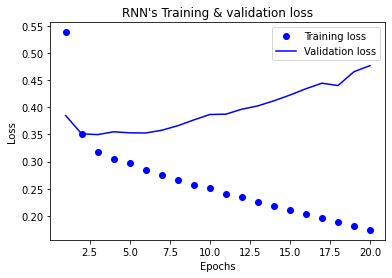

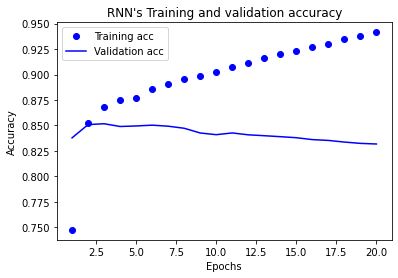

In [25]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### BPE 타입을 적용한 토크나이저를 사용하여 감정 분석 모델을 재학습하기

In [32]:
# 데이터 분할
X_train = tensor_bpe[:146182]
X_test = tensor_bpe[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 11ms/step - loss: 0.5402 - accuracy: 0.7529 - val_loss: 0.3860 - val_accuracy: 0.8377
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3468 - accuracy: 0.8566 - val_loss: 0.3545 - val_accuracy: 0.8478
Epoch 3/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3097 - accuracy: 0.8744 - val_loss: 0.3485 - val_accuracy: 0.8513
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2908 - accuracy: 0.8832 - val_loss: 0.3519 - val_accuracy: 0.8500
Epoch 5/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2775 - accuracy: 0.8893 - val_loss: 0.3586 - val_accuracy: 0.8482
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2667 - accuracy: 0.8947 - val_loss: 0.3626 - val_accuracy: 0.8463
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2562 - accuracy: 0.8994 - val_loss: 0.3678 - val_accuracy: 0.8459
Epoch

1537/1537 - 4s - loss: 0.6108 - accuracy: 0.8269
[0.6107655763626099, 0.8269015550613403]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


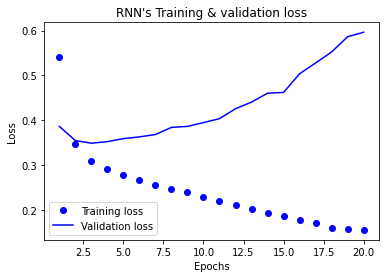

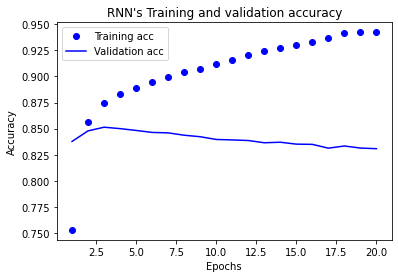

In [35]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [36]:
from konlpy.tag import Mecab
tokenizer = Mecab() # Mecab 형태소 분석기 인스턴스 생성
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)     # 중복 제거
    train_data = train_data.dropna(how = 'any')     # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)    # 중복 제거
    test_data = test_data.dropna(how = 'any')     # 결측치 제거

    # 훈련 데이터 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    # 테스트 데이터 토큰화 및 불용어 제거
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 단어 목록 생성 및 빈도수 기반 상위 num_words 선택
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4) # 4개의 특수 토큰을 위한 공간 확보
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 단어-인덱스 매핑 사전 생성
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 텍스트 데이터를 인덱스 데이터로 변환하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    # 훈련 데이터와 테스트 데이터를 인덱스 데이터로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # 변환된 데이터와 레이블을 반환
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 함수 호출하여 데이터 로딩 및 전처리
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [37]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [38]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [39]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [40]:
# 데이터셋 내 문장 길이 분포 파악
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [41]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [42]:
# 적절한 최대 문장 길이를 지정
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 설정  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [43]:
# 패딩 작업
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [44]:
#  validation set 구성
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [45]:

import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 0.5131 - accuracy: 0.7732 - val_loss: 0.3770 - val_accuracy: 0.8377
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3492 - accuracy: 0.8530 - val_loss: 0.3516 - val_accuracy: 0.8481
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3197 - accuracy: 0.8675 - val_loss: 0.3495 - val_accuracy: 0.8486
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3053 - accuracy: 0.8738 - val_loss: 0.3526 - val_accuracy: 0.8485
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2937 - accuracy: 0.8803 - val_loss: 0.3539 - val_accuracy: 0.8473
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2838 - accuracy: 0.8852 - val_loss: 0.3624 - val_accuracy: 0.8470
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2738 - accuracy: 0.8893 - val_loss: 0.3659 - val_accuracy: 0.8457
Epoch 

1537/1537 - 3s - loss: 0.5984 - accuracy: 0.8317
[0.5984402298927307, 0.8317431807518005]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


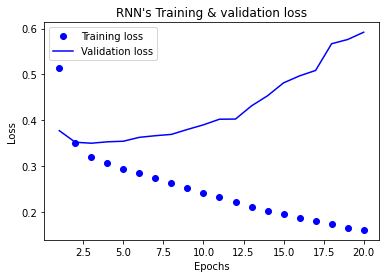

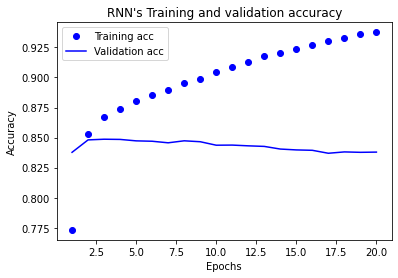

In [47]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고
1. 전처리 과정에서 train과 test 데이터 셋이 따로 되어 있어서 처음에는 각자 전처리를 진행하다가 인터넷을 뒤져보니 같이 진행한 것을 보고 나도 같이 진행하였다. 데이터를 list로 변환해서 합쳤고 이후에는 NaN값 제거와 중복치 제거를 수행하였다. SentencePiece 적용에서는 Unigram과 BPE 모델을 모두 학습시켜 모델 파일과 vocab 파일을 생성하였고 인코딩과 디코딩이 잘 수행되는지 확인하였다.
2. RNN 기반으로 구성된 Unigram타입이 적용된 모델은 82.7, BPE는 82.6으로 거의 비슷한 정확성을 보여주었다. KoNLPy형태소 분석기와 함께 돌렸을 때에는 83.17이라는 비교적 높은 정확성을 보여주었다. 내가 생각하는 그 이유로는 한국어 특성 상 서브워드 보다 형태소 분석기가 더 잘 맞기 때문인 것 같다.
3. 프로젝트 결과에 따르면, KoNLPy 형태소 분석기가 Unigram과 BPE 기반 SentencePiece 모델보다 약간 더 높은 정확도를 보여주었습니다. 위에서 말했듯이 한국어의 특성상 형태소 구조가 문장에 있어서 중요한 역할을 해서 정확도가 더 높게 나온 것 같습니다. BPE와 Unigram의 성능 차이가 미미한 것은 데이터셋 자체에서의 서브워드 패턴이 비슷하기 때문인 것 같습니다. OOV 문제는 서브워드 기반 토큰화에서 크게 문제가 되지 않았을 것으로 된 것 같다.ㄴ

전처리를 시작부터 감을 못 잡으니깐 시작이 안 되었다.
단어를 계속 보고 있으니깐 눈이 빠질 것 같다. 앞으로 설레면서도 힘들다.